In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
from scipy import integrate
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor, VotingRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [23]:
#load the dataset
Pi = []
filename = "π(x).csv"

with open(filename, mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        number_of_primes = int(row[1])  # the second column contains the number of primes below x
        Pi.append(number_of_primes)

#create DataFrame
df = pd.DataFrame({
    "x": [i + 1 for i in range(0, 100000)],  
    "pi_x": [Pi[i] for i in range(0, 100000)]
})

## Advanced Feature Engineering Based on Number Theory 

We'll create features based on known approximations of π(x) from number theory, these features will be used for Multiple Linear Regression:
- $\dfrac{x}{\ln(x)}$ (Prime Number Theorem)
- $\mathrm{Li}(x)$ (Logarithmic Integral)  
- $\dfrac{x}{\ln(x) - 1.08366}$ (Legendre's approximation)
- Other miscellaneous math functions that may be useful as a feature: $\ln(x)$ , $x^2$ , $\sqrt{x}$ , $(\ln(x))^2$ , $x \ln(x)$

In [24]:
#function to approximate Li(x) - the logarithmic integral
def li_approx(x):
    if x <= 1:
        return 0
    #use a simple approximation for efficiency
    return x / np.log(x) + 1.04 * x / (np.log(x)**2)

# create feature engineering function
def engineer_features(df, max_samples=None):
    # limit samples if specified
    if max_samples:
        df = df.iloc[:max_samples].copy()
    else:
        df = df.copy()

    #basic transformations
    df['log_x'] = np.log(df['x'])

    #Prime Number Theorem (x/ln(x)) approximation
    df['x_div_logx'] = df['x'] / np.maximum(df['log_x'], 0.001)  # Avoid division by zero
    
    # Logarithmic integral approximation
    df['li_x'] = df['x'].apply(li_approx)
    
    #additional miscellaneous mathematical transformations
    df['x_squared'] = df['x'] ** 2
    df['sqrt_x'] = np.sqrt(df['x'])
    df['log_squared'] = df['log_x'] ** 2
    df['x_times_log'] = df['x'] * df['log_x']
    
    #Legendre's approximation
    df['legendre'] = df['x'] / np.maximum(df['log_x'] - 1.08366, 0.001)  # Avoid division by zero
    
    return df

# apply feature engineering to a subset for visualization
df_sample = engineer_features(df.iloc[:1000])
print("Engineered features:")
print(df_sample.head())

Engineered features:
   x  pi_x     log_x   x_div_logx      li_x  x_squared    sqrt_x  log_squared  \
0  1     0  0.000000  1000.000000  0.000000          1  1.000000     0.000000   
1  2     1  0.693147     2.885390  7.214638          4  1.414214     0.480453   
2  3     2  1.098612     2.730718  5.315748          9  1.732051     1.206949   
3  4     2  1.386294     2.885390  5.050014         16  2.000000     1.921812   
4  5     3  1.609438     3.106675  5.114172         25  2.236068     2.590290   

   x_times_log     legendre  
0     0.000000  1000.000000  
1     1.386294  2000.000000  
2     3.295837   200.638181  
3     5.545177    13.217270  
4     8.047190     9.509719  


## Data Preparation and Scaling

Data scaling so model converges faster.

In [25]:
max_samples = 100000  #use the full dataset
df_model = engineer_features(df, max_samples)

# define features and target
feature_cols = ['x', 'log_x', 'sqrt_x', 'x_div_logx', 'li_x', 'x_squared', 
                'log_squared', 'x_times_log', 'legendre']
X = df_model[feature_cols]
y = df_model['pi_x']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (80000, 9)
Testing set size: (20000, 9)


## Neural Network Model

The model is built using Keras `Sequential` API with the following layers:

- Dense(128, activation='relu') with input shape  
- Dropout(0.3)  
- Dense(64, activation='relu')  
- Dropout(0.2)  
- Dense(32, activation='relu')  
- Dense(1) ->output layer for regression
---
## Compilation

- **Optimiser**: Adam (learning rate = 0.001)  
- **Loss**: Mean Squared Error (`mse`)  
- **Metrics**: Mean Squared Error
---
## Training Configuration

- **Epochs**: 100  
- **Batch Size**: 32  
- **Validation Split**: 20%  
- **EarlyStopping**:
  - Monitor: `'val_loss'`
  - Patience: 10
  - `restore_best_weights=True`

In [26]:
# force Cpu usage and minimal model
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # force Cpu only
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')  # disable Gpu

#  create a neural network  model
def create_nn_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer
    ])
    
    # compile the model with the custom loss function
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss = 'mse',
        metrics=['mse']
    )
    
    return model

#create and train the neural network
nn_model = create_nn_model(X_train_scaled.shape[1])

# early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

#train the model
history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 9718534.0000 - mse: 9718534.0000 - val_loss: 25242.0430 - val_mse: 25242.0430
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 311878.9688 - mse: 311878.9688 - val_loss: 1998.4376 - val_mse: 1998.4376
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 956us/step - loss: 300284.2188 - mse: 300284.2188 - val_loss: 7902.0391 - val_mse: 7902.0391
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 935us/step - loss: 293966.1562 - mse: 293966.1562 - val_loss: 6081.9937 - val_mse: 6081.9937
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 878us/step - loss: 281787.9375 - mse: 281787.9375 - val_loss: 8087.9946 - val_mse: 8087.9946
Epoch 6/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 907us/step - loss: 274710.5625 - mse: 274710.5625 - val_loss: 28043.1680 - val_mse: 28043.1680
Epoch 7/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 272016.6562 - mse: 272016.6562 - val_loss: 2697.5798 - val_mse: 2697.5798
Epoch 8/100
2000/2000 ━━━━━

## Model Evaluation

In [27]:
# make predictions with neural network
y_pred_nn = nn_model.predict(X_test_scaled).flatten()
#calculate percentage error
actual = np.array(y_test)
predicted = np.array(y_pred_nn)

#remove zero values to avoid division by zero
mask = actual != 0
actual_non_zero = actual[mask]
predicted_non_zero = predicted[mask]

#calculate percentage errors
percentage_errors = np.abs((actual_non_zero - predicted_non_zero) / actual_non_zero) * 100
mape = np.mean(percentage_errors)

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
Mean Absolute Percentage Error (MAPE): 2.69%


In [28]:
#define the inputs
large_nums = [[10**6], [10**7], [10**8]]
actual_pi_x = np.array([78498, 664579, 5761455])  # Actual number of primes

#create DataFrame
df_large = pd.DataFrame(large_nums, columns=['x'])

#engineer features
df_large_features = engineer_features(df_large)
df_large_features = df_large_features[feature_cols]

# scale features
df_large_scaled = scaler.transform(df_large_features)

#predict
y_pred_large = nn_model.predict(df_large_scaled).flatten()

#calculate and print percentage errors
percentage_errors = np.abs((actual_pi_x - y_pred_large) / actual_pi_x) * 100

for i in range(3):
   print(f"Absolute Percentage Error (APE) for x=10^{6+i}: {percentage_errors[i].item():.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Absolute Percentage Error (APE) for x=10^6: 56.98%
Absolute Percentage Error (APE) for x=10^7: 1198.08%
Absolute Percentage Error (APE) for x=10^8: 14386.10%


## Visualise Model Performance

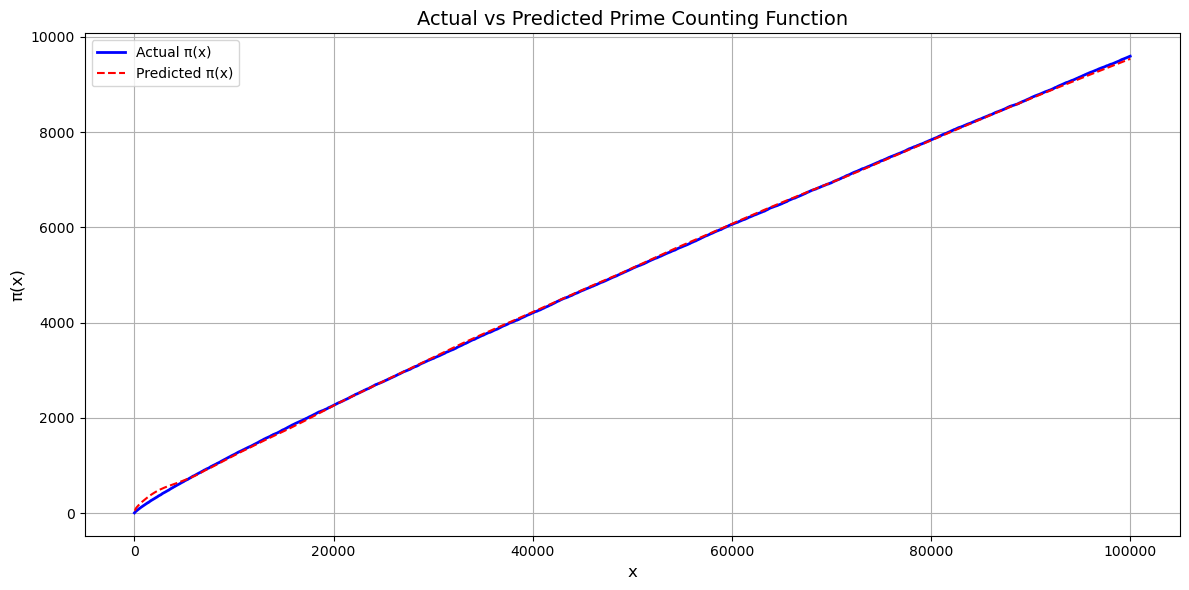

In [29]:
# create a DataFrame for visualization
results_df = pd.DataFrame({
    'x': X_test['x'],
    'Actual': y_test,
    'Predicted': y_pred_nn,
    'Error': y_pred_nn - y_test
})

# calculate percentage error
results_df['Percentage_Error'] = np.abs(results_df['Error'] / results_df['Actual']) * 100

# Sort by x for better visualization
results_df = results_df.sort_values('x')

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(results_df['x'], results_df['Actual'], 'b-', linewidth=2, label='Actual π(x)')
plt.plot(results_df['x'], results_df['Predicted'], 'r--', linewidth=1.5, label='Predicted π(x)')
plt.xlabel('x', fontsize=12)
plt.ylabel('π(x)', fontsize=12)
plt.title('Actual vs Predicted Prime Counting Function', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

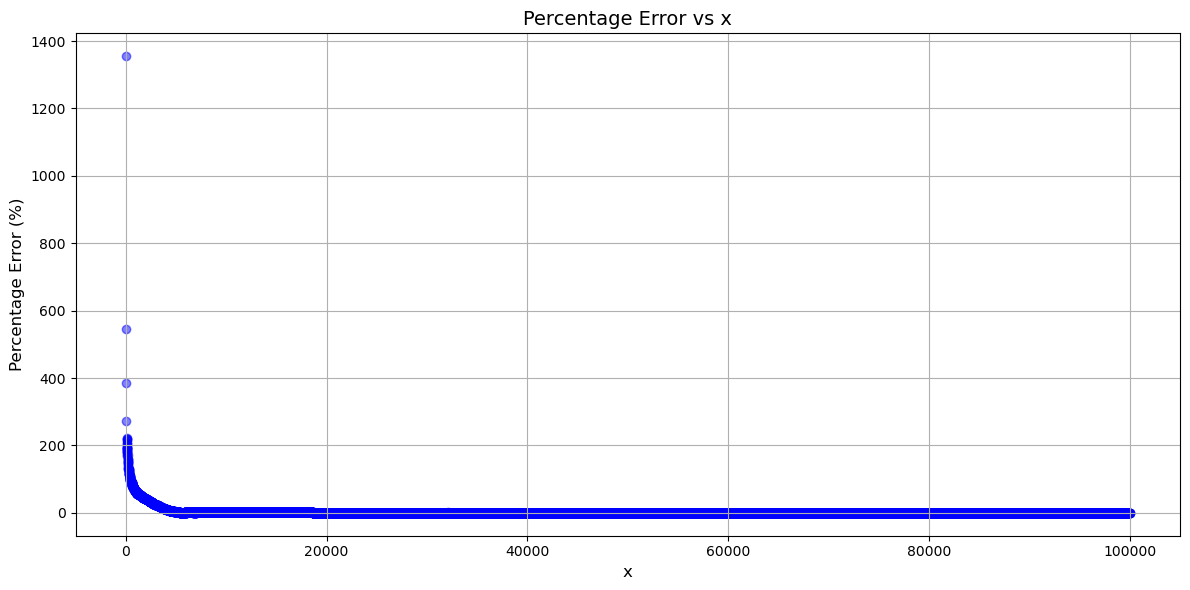

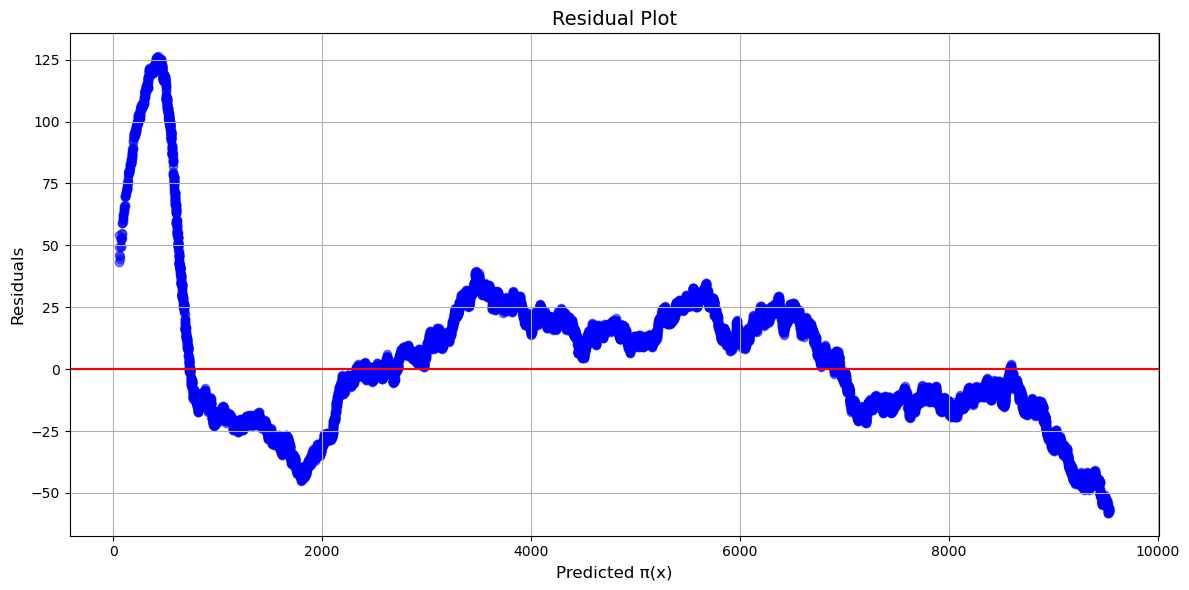

In [30]:
# plot error vs x
plt.figure(figsize=(12, 6))
plt.scatter(results_df['x'], results_df['Percentage_Error'], alpha=0.5, color='blue')
plt.xlabel('x', fontsize=12)
plt.ylabel('Percentage Error (%)', fontsize=12)
plt.title('Percentage Error vs x', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(results_df['Predicted'], results_df['Error'], alpha=0.5, color='blue')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted π(x)', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()